In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Prepare Dataset**

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mksaad/wider-face-a-face-detection-benchmark")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/wider-face-a-face-detection-benchmark


In [3]:
import os

for root, dirs, files in os.walk(path):
    print(root)

/kaggle/input/wider-face-a-face-detection-benchmark
/kaggle/input/wider-face-a-face-detection-benchmark/WIDER_train
/kaggle/input/wider-face-a-face-detection-benchmark/WIDER_train/WIDER_train
/kaggle/input/wider-face-a-face-detection-benchmark/WIDER_train/WIDER_train/images
/kaggle/input/wider-face-a-face-detection-benchmark/WIDER_train/WIDER_train/images/42--Car_Racing
/kaggle/input/wider-face-a-face-detection-benchmark/WIDER_train/WIDER_train/images/0--Parade
/kaggle/input/wider-face-a-face-detection-benchmark/WIDER_train/WIDER_train/images/22--Picnic
/kaggle/input/wider-face-a-face-detection-benchmark/WIDER_train/WIDER_train/images/11--Meeting
/kaggle/input/wider-face-a-face-detection-benchmark/WIDER_train/WIDER_train/images/16--Award_Ceremony
/kaggle/input/wider-face-a-face-detection-benchmark/WIDER_train/WIDER_train/images/12--Group
/kaggle/input/wider-face-a-face-detection-benchmark/WIDER_train/WIDER_train/images/57--Angler
/kaggle/input/wider-face-a-face-detection-benchmark/WIDE

In [4]:
target_file = ["wider_face_train_bbx_gt.txt", "wider_face_val_bbx_gt.txt"]

for root, dirs, files in os.walk(path):
  for i in range(len(target_file)):
      if target_file[i] in files:
          print(f"✅ Found {target_file[i]} in:")
          print(f"Root: {root}")
          print(f"Full Path: {os.path.join(root, target_file[i])}")

✅ Found wider_face_train_bbx_gt.txt in:
Root: /kaggle/input/wider-face-a-face-detection-benchmark/wider_face_split/wider_face_split
Full Path: /kaggle/input/wider-face-a-face-detection-benchmark/wider_face_split/wider_face_split/wider_face_train_bbx_gt.txt
✅ Found wider_face_val_bbx_gt.txt in:
Root: /kaggle/input/wider-face-a-face-detection-benchmark/wider_face_split/wider_face_split
Full Path: /kaggle/input/wider-face-a-face-detection-benchmark/wider_face_split/wider_face_split/wider_face_val_bbx_gt.txt


In [5]:
import os
import shutil
from PIL import Image

def convert_wider_to_yolo(annotation_file, img_dir, images_output_dir, labels_output_dir):
    os.makedirs(images_output_dir, exist_ok=True)
    os.makedirs(labels_output_dir, exist_ok=True)

    with open(annotation_file, 'r') as f:
        lines = f.readlines()

    i = 0
    count = 0
    while i < len(lines):
        img_rel_path = lines[i].strip()
        num_faces = int(lines[i+1].strip())
        bboxes = []

        for j in range(num_faces):
            box = lines[i+2+j].strip().split()
            x, y, w, h = map(int, box[:4])
            bboxes.append([x, y, w, h])
        i += 2 + num_faces

        img_full_path = os.path.join(img_dir, img_rel_path)
        try:
            img = Image.open(img_full_path)
            img_width, img_height = img.size
        except Exception as e:
            print(f"[Warning] Cannot open {img_full_path}. Skipping. Error: {e}")
            continue

        # Copy ảnh sang thư mục output chuẩn YOLO
        img_name = os.path.basename(img_rel_path)
        img_output_path = os.path.join(images_output_dir, img_name)
        os.makedirs(os.path.dirname(img_output_path), exist_ok=True)
        shutil.copyfile(img_full_path, img_output_path)

        # Ghi label YOLO
        label_name = img_name.replace('.jpg', '.txt')
        label_output_path = os.path.join(labels_output_dir, label_name)
        with open(label_output_path, 'w') as f_label:
            for x, y, w, h in bboxes:
                x_center = (x + w / 2) / img_width
                y_center = (y + h / 2) / img_height
                w_norm = w / img_width
                h_norm = h / img_height
                f_label.write(f"0 {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")

        count += 1
        if count % 1000 == 0:
            print(f"Processed {count} images...")

    print(f"✅ Conversion done: {count} images & labels prepared.")

# ---------- YOLO format ----------

base_path = '/content/wider_face_to_yolo_datasets'

# Convert train
convert_wider_to_yolo(
    '/kaggle/input/wider-face-a-face-detection-benchmark/wider_face_split/wider_face_split/wider_face_train_bbx_gt.txt',
    '/kaggle/input/wider-face-a-face-detection-benchmark/WIDER_train/WIDER_train/images',
    os.path.join(base_path, 'images/train'),
    os.path.join(base_path, 'labels/train')
)

# Convert val
convert_wider_to_yolo(
    '/kaggle/input/wider-face-a-face-detection-benchmark/wider_face_split/wider_face_split/wider_face_val_bbx_gt.txt',
    '/kaggle/input/wider-face-a-face-detection-benchmark/WIDER_val/WIDER_val/images',
    os.path.join(base_path, 'images/val'),
    os.path.join(base_path, 'labels/val')
)


Processed 1000 images...
Processed 2000 images...
Processed 3000 images...
Processed 4000 images...
Processed 5000 images...
Processed 6000 images...
Processed 7000 images...
Processed 8000 images...
Processed 9000 images...
Processed 10000 images...
Processed 11000 images...
Processed 12000 images...
✅ Conversion done: 12880 images & labels prepared.
Processed 1000 images...
Processed 2000 images...
Processed 3000 images...
✅ Conversion done: 3226 images & labels prepared.


In [6]:
names = ['face']

yaml_content = """
path: /content/wider_face_to_yolo_datasets
train: images/train
val: images/val
nc: 1
names: ['face']
"""

with open("/content/wider_face_to_yolo_datasets/data.yaml", "w") as f:
    f.write(yaml_content.strip())

print("✅ Created data.yaml successfully.")


✅ Created data.yaml successfully.


In [7]:
!cat /content/wider_face_to_yolo_datasets/data.yaml


path: /content/wider_face_to_yolo_datasets
train: images/train
val: images/val
nc: 1
names: ['face']

In [6]:
!pip install ultralytics

## **Model and training**

In [ ]:
from ultralytics import YOLO
import os

# Load a model
model_path = "/content/drive/MyDrive/Face_detection_pretrained_model/Face_detection_yolov5mu/best.pt"
model = YOLO("yolov5mu.pt")  # load a pretrained model

# Define the correct path to the data.yaml file
yolo_yaml_path = os.path.join("/content/wider_face_to_yolo_datasets", "data.yaml")


# Train the model (50 epochs)
results = model.train(
    data=yolo_yaml_path,
    epochs=25, # pre-trained from before 25 epochs
    imgsz=320,
    batch=64,
    optimizer="Adam",
    cache=True,
    patience=20,
    plots=True,
    model=model_path
)

Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/wider_face_to_yolo_datasets/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/Face_detection_pretrained_model/Face_detection_yolov5mu/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optim

train: Scanning /content/wider_face_to_yolo_datasets/labels/train.cache... 12880 images, 0 backgrounds, 2 corrupt: 100%|██████████| 12880/12880 [00:00<?, ?it/s]

train: /content/wider_face_to_yolo_datasets/images/train/2_Demonstration_Protesters_2_231.jpg: 1 duplicate labels removed
train: /content/wider_face_to_yolo_datasets/images/train/37_Soccer_Soccer_37_851.jpg: 1 duplicate labels removed
train: /content/wider_face_to_yolo_datasets/images/train/54_Rescue_rescuepeople_54_29.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0127]
train: /content/wider_face_to_yolo_datasets/images/train/7_Cheering_Cheering_7_17.jpg: ignoring corrupt image/label: negative class labels [  -0.010742]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (2.6GB RAM): 100%|██████████| 12878/12878 [01:24<00:00, 151.62it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 17.2±5.2 MB/s, size: 117.6 KB)


val: Scanning /content/wider_face_to_yolo_datasets/labels/val.cache... 3226 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3226/3226 [00:00<?, ?it/s]

val: /content/wider_face_to_yolo_datasets/images/val/21_Festival_Festival_21_604.jpg: 1 duplicate labels removed


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.6GB RAM): 100%|██████████| 3226/3226 [00:20<00:00, 155.93it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 91 weight(decay=0.0), 98 weight(decay=0.0005), 97 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      10.6G      2.016      1.415      1.136        294        320: 100%|██████████| 202/202 [01:56<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]


                   all       3226      39707      0.321      0.138      0.109     0.0476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.2G      1.933      1.177      1.082        184        320: 100%|██████████| 202/202 [01:57<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


                   all       3226      39707      0.538      0.233      0.234     0.0992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      13.7G      1.886      1.153      1.075        148        320: 100%|██████████| 202/202 [01:57<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


                   all       3226      39707      0.422      0.162       0.15     0.0673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      12.8G      1.825      1.082       1.06        211        320: 100%|██████████| 202/202 [01:55<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.37it/s]


                   all       3226      39707      0.653      0.294      0.323      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      10.5G      1.773      1.033      1.045        301        320: 100%|██████████| 202/202 [01:56<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


                   all       3226      39707      0.678      0.314       0.35      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25        11G      1.738      1.007      1.039        201        320: 100%|██████████| 202/202 [01:58<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


                   all       3226      39707      0.668      0.315      0.348      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      12.3G      1.703      0.981      1.031        216        320: 100%|██████████| 202/202 [01:56<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.44it/s]


                   all       3226      39707      0.675      0.317      0.355      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      13.8G      1.695     0.9686      1.026        253        320: 100%|██████████| 202/202 [01:57<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]


                   all       3226      39707      0.687      0.326      0.378      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      10.2G      1.664     0.9428       1.02        166        320: 100%|██████████| 202/202 [01:55<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


                   all       3226      39707      0.672      0.319      0.356      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      10.7G      1.653     0.9358      1.015        129        320: 100%|██████████| 202/202 [01:56<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


                   all       3226      39707      0.702      0.343       0.38      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      12.7G      1.636     0.9175      1.009        488        320: 100%|██████████| 202/202 [01:57<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]

                   all       3226      39707        0.8      0.223      0.321       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      10.2G      1.615     0.8968      1.006        170        320: 100%|██████████| 202/202 [01:56<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


                   all       3226      39707      0.727      0.347      0.412       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      12.9G       1.59     0.8784      1.001        332        320: 100%|██████████| 202/202 [01:55<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


                   all       3226      39707      0.731      0.353      0.414      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      13.7G      1.592     0.8712     0.9907        317        320: 100%|██████████| 202/202 [01:56<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


                   all       3226      39707      0.733      0.354        0.4      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      14.1G      1.568     0.8544     0.9894        166        320: 100%|██████████| 202/202 [01:56<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


                   all       3226      39707       0.73      0.363      0.412      0.216
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      13.8G      1.558     0.8476     0.9929        148        320: 100%|██████████| 202/202 [01:57<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


                   all       3226      39707      0.761      0.344      0.409      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      13.6G      1.545       0.83     0.9918        151        320: 100%|██████████| 202/202 [01:55<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


                   all       3226      39707      0.735       0.36       0.41      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      12.4G      1.536     0.8171     0.9856        472        320: 100%|██████████| 202/202 [01:55<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


                   all       3226      39707      0.747      0.364      0.412      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      10.9G      1.511     0.7991     0.9824         58        320: 100%|██████████| 202/202 [01:55<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


                   all       3226      39707      0.755      0.368      0.429      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      14.1G      1.491     0.7824     0.9751        110        320: 100%|██████████| 202/202 [01:54<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


                   all       3226      39707      0.767      0.373       0.44      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      12.6G      1.472     0.7653     0.9716        126        320: 100%|██████████| 202/202 [01:54<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]


                   all       3226      39707      0.753      0.381      0.434      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      13.9G      1.459     0.7494     0.9671        132        320: 100%|██████████| 202/202 [01:54<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


                   all       3226      39707      0.755      0.387      0.443      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      12.5G      1.439     0.7334     0.9632         38        320: 100%|██████████| 202/202 [01:55<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


                   all       3226      39707      0.758      0.382      0.439      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.7G      1.418     0.7123     0.9547         62        320: 100%|██████████| 202/202 [01:54<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


                   all       3226      39707      0.766      0.393      0.453      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      12.3G      1.396      0.692     0.9511         61        320: 100%|██████████| 202/202 [01:54<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


                   all       3226      39707      0.767      0.398       0.46       0.25

25 epochs completed in 1.016 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 50.4MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 50.4MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv5m summary (fused): 106 layers, 25,045,795 parameters, 0 gradients, 64.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.34it/s]


                   all       3226      39707      0.767      0.398       0.46       0.25
Speed: 0.0ms preprocess, 1.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train4


In [8]:
import shutil
import os

source_path = '/content/runs/detect/train4/weights/best.pt'
destination_path = '/content/drive/MyDrive/Face_detection_pretrained_model/Face_detection_yolov5mu/best.pt'

# Create the destination directory if it doesn't exist
os.makedirs(os.path.dirname(destination_path), exist_ok=True)

shutil.copy(source_path, destination_path)
print(f"File copied to {destination_path}")

File copied to /content/drive/MyDrive/Face_detection_pretrained_model/Face_detection_yolov5mu/best.pt


## **Evaluate**

In [9]:
model_path = '/content/drive/MyDrive/Face_detection_pretrained_model/Face_detection_yolov5mu/best.pt'
model = YOLO(model_path)
metrics = model.val()

Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv5m summary (fused): 106 layers, 25,045,795 parameters, 0 gradients, 64.0 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1748.4±506.1 MB/s, size: 76.1 KB)


val: Scanning /content/wider_face_to_yolo_datasets/labels/val.cache... 3226 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3226/3226 [00:00<?, ?it/s]

val: /content/wider_face_to_yolo_datasets/images/val/21_Festival_Festival_21_604.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 202/202 [00:29<00:00,  6.91it/s]


                   all       3226      39707      0.766      0.398       0.46       0.25
Speed: 0.1ms preprocess, 3.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val


In [14]:
# Show val detect
import matplotlib.pyplot as plt

# Labels
print("Labels:")
img = plt.imread("/content/runs/detect/val/val_batch0_labels.jpg")
plt.figure(figsize=(18, 18))
plt.imshow(img)
plt.axis('off')
plt.show()

# Pred
print("\nPred:")
img = plt.imread("/content/runs/detect/val/val_batch0_pred.jpg")
plt.figure(figsize=(18, 18))
plt.imshow(img)
plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## **Show result**


image 1/1 /content/drive/MyDrive/Face_detection_pretrained_model/test face detection yolo.jpg: 224x320 21 faces, 96.5ms
Speed: 11.1ms preprocess, 96.5ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 320)


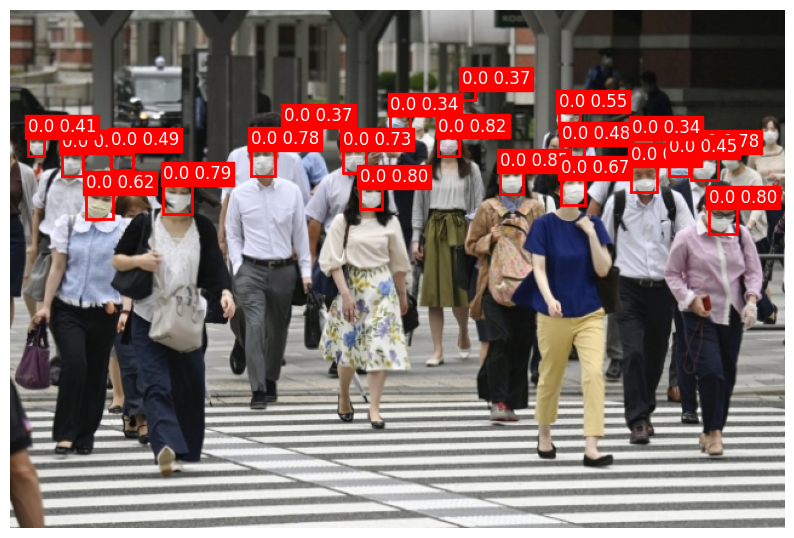

In [15]:
from PIL import Image
import matplotlib.pyplot as plt

input_image_path = "/content/drive/MyDrive/Face_detection_pretrained_model/test face detection yolo.jpg"
image = Image.open(input_image_path)

train_model_path = "/content/drive/MyDrive/Face_detection_pretrained_model/Face_detection_yolov5mu/best.pt"

model = YOLO(train_model_path)
results = model.predict(source=input_image_path)

# Plot the image and draw the bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image)
ax = plt.gca()

# Extract predictions
for result in results:
    # Extract bounding box coordinates
    boxes = result.boxes.xyxy.cpu().numpy()

    # Extract confidence scores
    scores = result.boxes.conf.cpu().numpy()

    # Extract class labels
    labels = result.boxes.cls.cpu().numpy()

    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box
        width, height = x2 - x1, y2 - y1

        # Draw the bounding box
        rect = plt.Rectangle((x1, y1), width, height, edgecolor='red', facecolor='none', linewidth=2)
        ax.add_patch(rect)

        # Draw the label and confidence
        plt.text(x1, y1, f'{label} {score:.2f}', color='white', fontsize=12, bbox=dict(facecolor='red', edgecolor='red', pad=2.0))

plt.axis('off')
plt.show()
